In [1]:
import numpy as np
import quaternion
import math
from numpy import linalg as LA
from math import *
from pyluos import Robot
import time

x0 = [1, 0, 0]
y0 = [0, 1, 0]
z0 = [0, 0, 1]

x0_quat = quaternion.quaternion(0,1,0,0)
y0_quat = quaternion.quaternion(0,0,1,0)
z0_quat = quaternion.quaternion(0,0,0,1)

Pc = [0,0,89.40]   #Coordinates of the plateform's center
C = [0,0,64.227]   #Coordinates of the center of the proximal circle
R = 39.162   #Radius of the distal circle
Rp = R*cos(40.0*pi/180)   #Radius of the proximal center

/Users/augustin/.virtualenvs/spherical-joint/lib/python3.6/site-packages/quaternion/numba_wrapper.py:20: UserWarning: 

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Could not import from numba, which means that some
parts of this code may run MUCH more slowly.  You
may wish to install numba.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

  warnings.warn(warning_text)


In [2]:
def get_new_frame(vect,angle=0):

    beta = angle*math.pi/180


    ### GOAL VECTOR (the desired Z axis)###
    goal = vect


    goal_norm = []
    for i in goal:
        goal_norm.append(i/LA.norm(goal)) #Normalized vector of goal

    ### VECTOR AND ANGLE OF ROTATION ###
    vector= np.cross(z0,goal_norm)

    vector_norm = [] #Normalized vector of rotation
    for i in vector:
        vector_norm.append(i/LA.norm(vector))

    alpha = math.acos(np.vdot(z0,goal_norm)) #Angle of rotation

    if alpha == 0 :
        v = quaternion.quaternion(0.0,0.0,0.0,1.0)

    else :  
        v = quaternion.quaternion(0.0,vector_norm[0],vector_norm[1],vector_norm[2]) #Vector of rotation as a quaternion





    ### QUATERNION OF ROTATION ###
    w1 = math.cos(alpha/2.0)
    x1 = math.sin(alpha/2.0)*v.x
    y1 = math.sin(alpha/2.0)*v.y
    z1 = math.sin(alpha/2.0)*v.z

    q1 = quaternion.quaternion(w1,x1,y1,z1) #1st rotation quaternion
    q1_inv = q1.inverse()

    z_prime = q1*z0_quat*q1_inv

    w2 = math.cos(beta/2.0)
    x2 = math.sin(beta/2.0)*z_prime.x
    y2 = math.sin(beta/2.0)*z_prime.y
    z2 = math.sin(beta/2.0)*z_prime.z

    q2 = quaternion.quaternion(w2,x2,y2,z2) #Quaternion of the rotation on new z axis
    q2_inv = q2.inverse()

    new_z = q2*z_prime*q2_inv #Final Z
    new_x = q2*(q1*x0_quat*q1_inv)*q2_inv #Final X
    new_y = q2*(q1*y0_quat*q1_inv)*q2_inv #Final Y

    X = [new_x.x, new_x.y, new_x.z]
    Y = [new_y.x, new_y.y, new_y.z]
    Z = [new_z.x, new_z.y, new_z.z]

    return X,Y,Z

In [3]:
def Q_angles(goal,beta=0):
    ### Find q31 and q11 ###
    X,Y,Z = get_new_frame(goal,beta)
    q31_ = [2*atan((R*X[2] - sqrt(R**2*X[2]**2 + R**2*Z[2]**2 - C[2]**2 + 2*C[2]*Pc[2] - Pc[2]**2))/(R*Z[2] + C[2] - Pc[2])), 2*atan((R*X[2] + sqrt(R**2*X[2]**2 + R**2*Z[2]**2 - C[2]**2 + 2*C[2]*Pc[2] - Pc[2]**2))/(R*Z[2] + C[2] - Pc[2]))]

    if 0<=q31_[0]<=180:
        q31 = q31_[0]
    else :
        q31= q31_[1]
    q11 = atan((Z[1]*cos(q31)+X[1]*sin(q31))/(Z[0]*cos(q31)+X[0]*sin(q31)))

    ### Find q32 and q12 ###
    X,Y,Z = get_new_frame(goal,beta+120)
    q32_ = [2*atan((R*X[2] - sqrt(R**2*X[2]**2 + R**2*Z[2]**2 - C[2]**2 + 2*C[2]*Pc[2] - Pc[2]**2))/(R*Z[2] + C[2] - Pc[2])), 2*atan((R*X[2] + sqrt(R**2*X[2]**2 + R**2*Z[2]**2 - C[2]**2 + 2*C[2]*Pc[2] - Pc[2]**2))/(R*Z[2] + C[2] - Pc[2]))]

    if 0<=q32_[0]<=180:
        q32 = q32_[0]
    else :
        q32= q32_[1]
    q12 = atan2((Z[1]*cos(q32)+X[1]*sin(q32)),(Z[0]*cos(q32)+X[0]*sin(q32)))
    
    ### Find q33 and q13 ###
    X,Y,Z = get_new_frame(goal,beta-120)
    q33_ = [2*atan((R*X[2] - sqrt(R**2*X[2]**2 + R**2*Z[2]**2 - C[2]**2 + 2*C[2]*Pc[2] - Pc[2]**2))/(R*Z[2] + C[2] - Pc[2])), 2*atan((R*X[2] + sqrt(R**2*X[2]**2 + R**2*Z[2]**2 - C[2]**2 + 2*C[2]*Pc[2] - Pc[2]**2))/(R*Z[2] + C[2] - Pc[2]))]

    if 0<=q33_[0]<=180:
        q33 = q33_[0]
    else :
        q33= q33_[1]
    q13 = atan2((Z[1]*cos(q33)+X[1]*sin(q33)),(Z[0]*cos(q33)+X[0]*sin(q33)))
    
    return [q11*180/pi,(q12*180/pi)-120,(q13*180/pi)+120]




In [4]:
r = Robot('/dev/cu.usbserial-DN05NM0L')


###########Setup############

r.disk_bottom.encoder_res = 5
r.disk_middle.encoder_res = 5
r.disk_top.encoder_res = 5


r.disk_bottom.setToZero()
r.disk_middle.setToZero()
r.disk_top.setToZero()


r.disk_bottom.reduction = 232
r.disk_middle.reduction = 232
r.disk_top.reduction = 232


r.disk_bottom.wheel_size = 60.0
r.disk_middle.wheel_size = 60.0
r.disk_top.wheel_size = 60


r.disk_bottom.positionPid = [9,0.02,100]
r.disk_middle.positionPid = [9,0.02,100]
r.disk_top.positionPid = [9,0.02,100]


r.disk_bottom.rot_position_mode(True)
r.disk_middle.rot_position_mode(True)
r.disk_top.rot_position_mode(True)

In [5]:
r.disk_bottom.compliant = True
r.disk_middle.compliant = True
r.disk_top.compliant = True

In [6]:
r.disk_bottom.compliant = False
r.disk_middle.compliant = False
r.disk_top.compliant = False

In [12]:
##### Remise à zéro #####
r.disk_bottom.target_rot_position = 0
r.disk_middle.target_rot_position = 0
r.disk_top.target_rot_position = 0

In [30]:
##### Test indiquer vecteur #####

locus = [0,0,1]
angle = 0

Q=Q_angles(locus,angle)

r.disk_top.target_rot_position = Q[0]
r.disk_middle.target_rot_position = Q[1]
r.disk_bottom.target_rot_position = Q[2]

/Users/augustin/.virtualenvs/spherical-joint/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


In [7]:
##### Tracé de cercle #####
Rtest = 4
centerTest = 10

i=1
t=0

while t<5*2.0*math.pi: #TEST CIRCLE PARAMETRIC EQUATION:
    locus = np.array([Rtest*math.cos(t),Rtest*math.sin(t),centerTest])
    i=i+1
    t=t+math.pi/30.0
    
    
    Q=Q_angles(locus)
    r.disk_top.target_rot_position = Q[0]
    r.disk_middle.target_rot_position = Q[1]
    r.disk_bottom.target_rot_position = Q[2]
    
    time.sleep(0.001)

In [7]:
##### Tracé de carré #####
L = 5.
cote1 = np.array([np.linspace(L,L,num=10),np.linspace(-L,L,num=10),np.linspace(10,10,num=10)])
cote2 = np.array([np.linspace(L,-L,num=10),np.linspace(L,L,num=10),np.linspace(10,10,num=10)])
cote3 = np.array([np.linspace(-L,-L,num=10),np.linspace(L,-L,num=10),np.linspace(10,10,num=10)])
cote4 = np.array([np.linspace(-L,L,num=10),np.linspace(-L,-L,num=10),np.linspace(10,10,num=10)])

poses = np.concatenate((cote1,cote2,cote3,cote4),axis=1)
poses = poses.transpose()

for i in range(len(poses)):
    pose = poses[i]

    
    Q=Q_angles(pose)
    r.disk_top.target_rot_position = Q[0]
    r.disk_middle.target_rot_position = Q[1]
    r.disk_bottom.target_rot_position = Q[2]
    
    time.sleep(0.05)

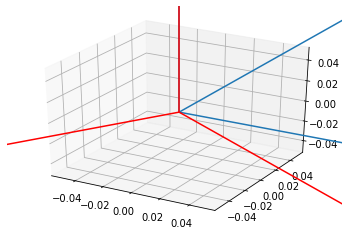

In [71]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



origin = [0,0,0]
X_, Y_, Z_ = zip(origin,origin,origin)
X0_,Y0_,Z0_ = zip(origin,origin,origin)
U, V, W = zip(X,Y,Z)
U0,V0,W0 = zip(x0,y0,z0)

fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
ax.quiver(X0_,Y0_,Z0_,U0,V0,W0,arrow_length_ratio=0.01)
ax.quiver(X_,Y_,Z_,U,V,W,arrow_length_ratio=0.01,color='r')
plt.show()

/Users/augustin/.virtualenvs/spherical-joint/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


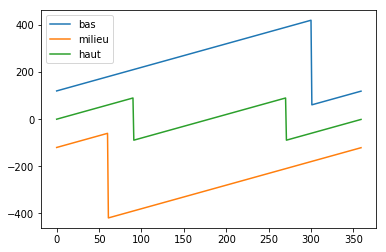

In [8]:
from matplotlib import pyplot as plt
locus = [0,0,1]

beta = []
for i in range(360):
    beta.append(i)

bas = []
milieu = []
haut = []

for _ in beta:

    Q=Q_angles(locus,_)
    haut.append(Q[0])
    milieu.append(Q[1]-120)
    bas.append(Q[2]+120)
    
plt.plot(beta,bas, label='bas')
plt.plot(beta,milieu, label='milieu')
plt.plot(beta,haut, label='haut')
plt.legend()